In [6]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [13]:
import numpy as np
import glob
from PIL import Image
from matplotlib.pyplot import imshow
import keras
from keras import layers
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf

def get_images(path,resize = True):  
    img_array = []
    label_array=[]
    img_paths=[]
    fpaths = glob.glob(path, recursive=True)
    
    for fname in fpaths:
        img = Image.open(fname).convert('L')
        if(resize): img = img.resize((64,64))
        img_array.append(np.asarray(img))
        img_paths.append(fname)
        
        if 'good' in fname.split("/"):
            label_array.append(0)
        else:
            label_array.append(1)
            
    paths=np.array(img_paths)
    images = np.array(img_array)
    labels= np.array(label_array)
    return images,labels,paths


In [14]:
def get_conv_model():
    encoding_dim = 1024
    dense_dim = [8, 8, 512] 
    input_img = keras.Input(train[0].shape)
    x = layers.Conv2D(64, 4,strides=2,  padding='same', activation='relu')(input_img) 
    x = layers.Conv2D(128, 4,strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, 4,strides=2,  padding='same', activation='relu')(x)
    x = layers.Conv2D(512, 4,strides=2,  padding='same', activation='relu')(x)
    x = layers.Flatten()(x)
    
    x= layers.Dense(encoding_dim,)(x)
    encoded = layers.Dense(encoding_dim,)(x)

    x = layers.Dense(np.prod(dense_dim))(encoded)
    x = layers.Reshape(target_shape=dense_dim)(x)
    x = layers.Conv2DTranspose(512, 4,strides=2,  padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(256, 4,strides=2,  padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(128, 4,strides=1,  padding='same', activation='relu')(x)
    decoded = layers.Conv2DTranspose(1,4, strides=2, padding='same', activation='sigmoid')(x)
    autoencoder = keras.Model(input_img, decoded)
    print(autoencoder.summary())
    return autoencoder

In [15]:
path_train = r"/content/drive/MyDrive/data/good/*.*"
path_test = r"/content/drive/MyDrive/data/test/**/*.*"
path_cont_test = r"/content/drive/MyDrive/data/test/contamination/*.*"
all_train,train_labels ,train_paths= get_images(path_train)
test ,test_labels,test_paths= get_images(path_test)
cont_test ,cont_test_labels,cont_test_paths= get_images(path_cont_test)
all_train = all_train.astype('float32') /255.
test = test.astype('float32') / 255.
cont_test = cont_test.astype('float32') / 255.
(train, val) = train_test_split(all_train, shuffle=False, train_size=0.8, random_state=1)
train = train.reshape(train.shape[0], train.shape[1], train.shape[2], 1)
val = val.reshape(val.shape[0], val.shape[1], val.shape[2], 1)
test = test.reshape(test.shape[0], test.shape[1], test.shape[2], 1)
cont_test = cont_test.reshape(cont_test.shape[0], cont_test.shape[1], cont_test.shape[2], 1)
#autoencoder = ResNetAE()
autoencoder =get_conv_model()
autoencoder.compile(optimizer='adam', loss='mse', metrics=['mae'])

es_callback = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
epochs=25
autoencoder_train=autoencoder.fit(train, train,
            epochs=epochs,
            batch_size=50,
            shuffle=True,
            validation_data=(val,val),
            callbacks=[es_callback])


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 64)        1088      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 128)       131200    
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 8, 256)         524544    
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 4, 512)         2097664   
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              8389

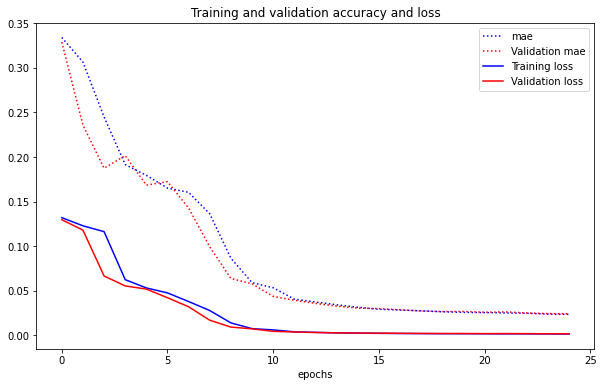

In [16]:
x=range(25)
loss = autoencoder_train.history['loss']
mae = autoencoder_train.history['mae']
val_mae = autoencoder_train.history['val_mae']
val_loss = autoencoder_train.history['val_loss']
plt.figure(figsize=(10,6))
plt.plot(x, mae, 'b:', label='mae')
plt.plot(x, val_mae, 'r:', label='Validation mae')
plt.plot(x, loss, 'b', label='Training loss')
plt.plot(x, val_loss, 'r', label='Validation loss')
plt.title('Training and validation accuracy and loss')
plt.xlabel('epochs')
plt.legend()
plt.show()


In [17]:
def get_error(imgs_true, imgs_pred):
    return np.sum(np.power(imgs_true - imgs_pred, 2))
    
          
train_pred = autoencoder.predict(train)
mse_vector=[]
mse_vector_test=[]
mse_vector_cont_test=[]
for i in range(train.shape[0]):
    mse_vector.append( get_error(train_pred[i], train[i]))

threshold = np.quantile(mse_vector, 0.90)

test_pred = autoencoder.predict(test)
cont_test_pred = autoencoder.predict(cont_test)
for i in range(test.shape[0]):
    mse_vector_test.append( get_error(test_pred[i], test[i]))
test_anomaly = (mse_vector_test > threshold)
print(test_anomaly)
for i in range(cont_test.shape[0]):
    mse_vector_cont_test.append( get_error(cont_test_pred[i], cont_test[i]))
cont_test_anomaly = (mse_vector_cont_test > threshold)
print('cont_test_anomaly',cont_test_anomaly)

[False  True False False False False False  True False False False False
 False False  True  True False False False False False  True  True False
 False  True  True  True False  True  True  True  True False  True False
  True False  True  True  True  True False  True  True False  True False
  True  True False  True False  True False  True False False  True  True
 False False  True  True  True  True False False  True False False False
  True False  True  True  True  True  True  True  True  True  True]
cont_test_anomaly [ True  True  True  True False False  True False False False  True False
  True  True  True  True  True  True  True  True  True]


(array([32., 75., 18., 14., 10.,  5.,  3.,  5.,  3.,  2.]),
 array([ 3.5536256,  4.985617 ,  6.417609 ,  7.849601 ,  9.281592 ,
        10.713584 , 12.145576 , 13.577568 , 15.00956  , 16.441551 ,
        17.873543 ], dtype=float32),
 <a list of 10 Patch objects>)

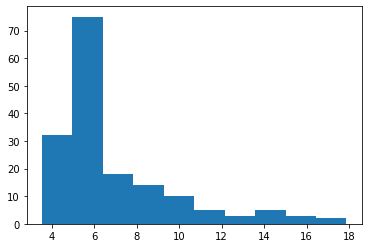

In [18]:
plt.hist(mse_vector)

(array([30., 21., 16.,  4.,  7.,  4.,  0.,  0.,  0.,  1.]),
 array([ 4.6765614,  8.814626 , 12.952691 , 17.090755 , 21.22882  ,
        25.366886 , 29.50495  , 33.643013 , 37.78108  , 41.919144 ,
        46.05721  ], dtype=float32),
 <a list of 10 Patch objects>)

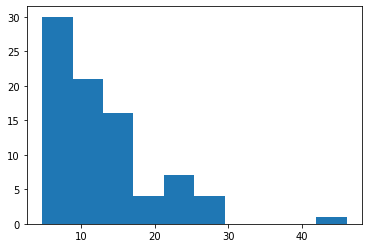

In [19]:
plt.hist(mse_vector_test)

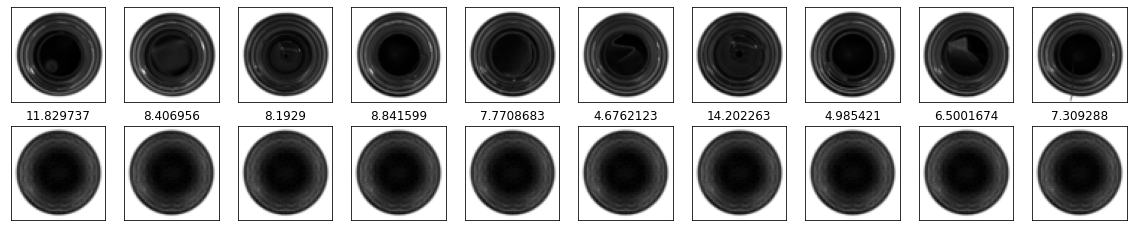

In [20]:

decoded_imgs = autoencoder.predict(cont_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(cont_test[i].reshape(64,64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(64,64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(get_error(decoded_imgs[i], test[i]))
plt.show()


In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report
print("Accuracy = {}".format(accuracy_score(test_labels, test_anomaly)))
print("Precision = {}".format(precision_score(test_labels, test_anomaly)))
print("Recall = {}".format(recall_score(test_labels, test_anomaly)))
print( classification_report(test_labels, test_anomaly))

Accuracy = 0.6746987951807228
Precision = 0.9090909090909091
Recall = 0.6349206349206349
              precision    recall  f1-score   support

           0       0.41      0.80      0.54        20
           1       0.91      0.63      0.75        63

    accuracy                           0.67        83
   macro avg       0.66      0.72      0.65        83
weighted avg       0.79      0.67      0.70        83



In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report
print("Accuracy = {}".format(accuracy_score(cont_test_labels, cont_test_anomaly)))
print("Precision = {}".format(precision_score(cont_test_labels, cont_test_anomaly)))
print("Recall = {}".format(recall_score(cont_test_labels, cont_test_anomaly)))
print( classification_report(cont_test_labels, cont_test_anomaly))

Accuracy = 0.7142857142857143
Precision = 1.0
Recall = 0.7142857142857143
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.71      0.83        21

    accuracy                           0.71        21
   macro avg       0.50      0.36      0.42        21
weighted avg       1.00      0.71      0.83        21



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
